In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
data = pd.concat(load_iris(return_X_y=True, as_frame=True), axis='columns')
data.sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
71,6.1,2.8,4.0,1.3,1
85,6.0,3.4,4.5,1.6,1
16,5.4,3.9,1.3,0.4,0
145,6.7,3.0,5.2,2.3,2
94,5.6,2.7,4.2,1.3,1


In [21]:
data.corr()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
sepal length (cm),1.000000,-0.117570,0.871754,0.817941,0.782561
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126,-0.426658
petal length (cm),0.871754,-0.428440,1.000000,0.962865,0.949035
petal width (cm),0.817941,-0.366126,0.962865,1.000000,0.956547
target,0.782561,-0.426658,0.949035,0.956547,1.000000


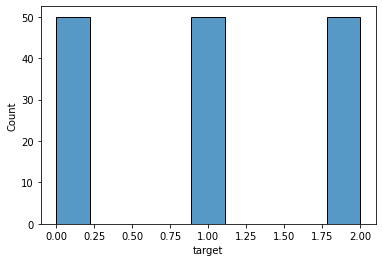

In [22]:
sns.histplot(data.target);

In [23]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, shuffle=True)

In [24]:
param_grid = {
    'n_estimators' : np.arange(100, 250, 50),
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'min_samples_leaf' : [1, 2],
    'min_samples_split' : [2, 3]
}
random_forest_model = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=4)
random_forest_model.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': array([100, 150, 200])})

In [25]:
accuracy_values = {}
accuracy_values["random_forest"] = accuracy_score(y_test, random_forest_model.predict(X_test))

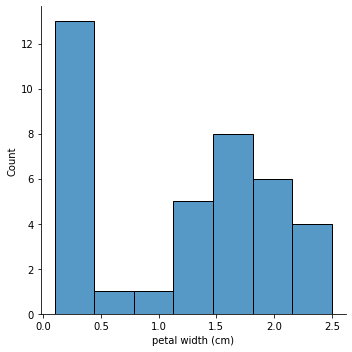

In [26]:
sns.displot(X_test['petal width (cm)']);

As we see from correlation matrix the correlation coefficient between $target$ and $petal width (cm)$ columns is high. Based on this information I will create model with prediction as rounding $petal width (cm)$ column values:

In [27]:
def my_simple_model(data : pd.Series) -> pd.Series:
    '''
    My experimental function
    '''
    res = np.around(data).astype(int)
    return res

In [28]:
accuracy_values["my_model"] = accuracy_score(y_test, my_simple_model(X_test["petal width (cm)"]))

In [29]:
svc_grid = {
    'C' : np.arange(1, 2, .2),
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree' : np.arange(1, 6, 1),
    'gamma' : ['scale', 'auto']
}
svc_model = GridSearchCV(SVC(), param_grid=svc_grid)
svc_model.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([1. , 1.2, 1.4, 1.6, 1.8]),
                         'degree': array([1, 2, 3, 4, 5]),
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [30]:
svc_model.best_params_

{'C': 1.0, 'degree': 1, 'gamma': 'scale', 'kernel': 'linear'}

In [31]:
accuracy_values["svm"] = accuracy_score(y_test, svc_model.predict(X_test)) 

In [32]:
param_grid = {
    'n_restarts_optimizer' : [1, 2],
    'max_iter_predict' : np.arange(50, 150, 20)
}
gaussian_model = GridSearchCV(GaussianProcessClassifier(), param_grid=param_grid, cv=4)
gaussian_model.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=GaussianProcessClassifier(),
             param_grid={'max_iter_predict': array([ 50,  70,  90, 110, 130]),
                         'n_restarts_optimizer': [1, 2]})

In [33]:
accuracy_values["gaussian"] = accuracy_score(y_test, gaussian_model.predict(X_test))

In [39]:
accuracy_values

{'random_forest': 0.8947368421052632,
 'my_model': 0.8421052631578947,
 'svm': 0.9210526315789473,
 'gaussian': 0.9473684210526315}

In [55]:
df_dict = {'name' : accuracy_values.keys(), 'accuracy_score' : accuracy_values.values()}

In [65]:
accuracy_scores_df = pd.DataFrame(df_dict).set_index('name').sort_values(by='accuracy_score', ascending=False)
accuracy_scores_df

,accuracy_score
name,
gaussian,0.947368
svm,0.921053
random_forest,0.894737
my_model,0.842105
